<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "L6b"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/L6b/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


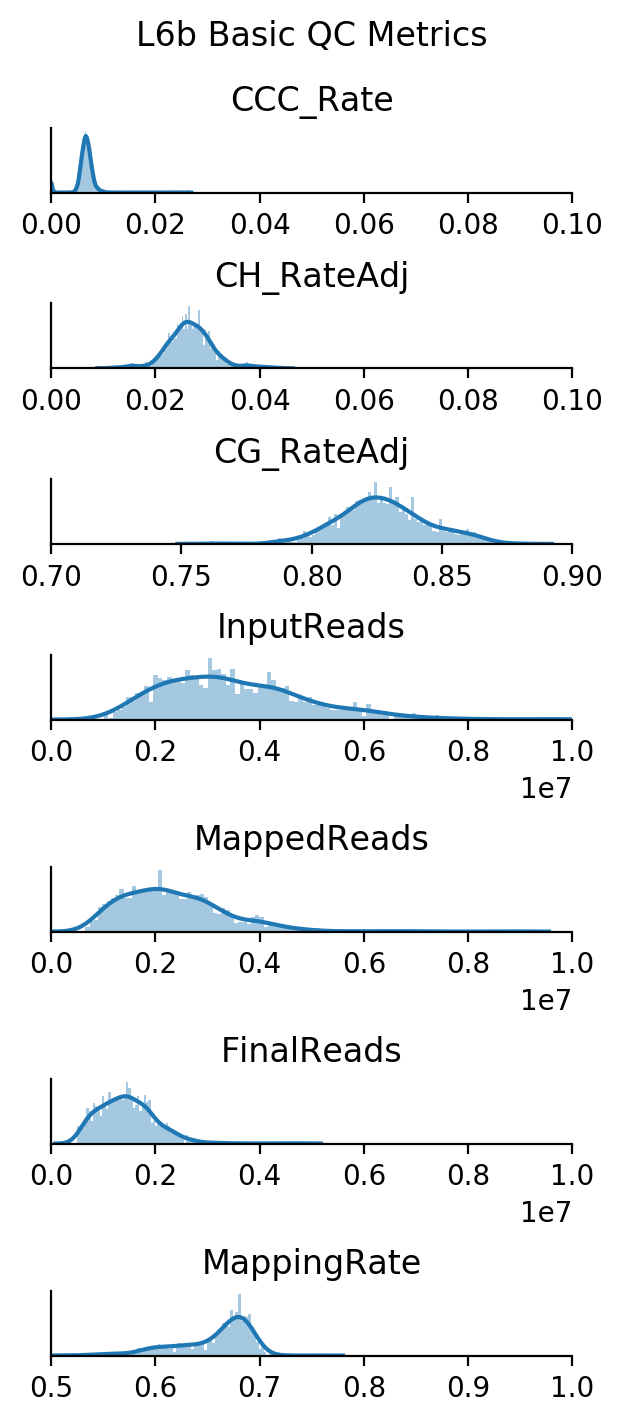

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

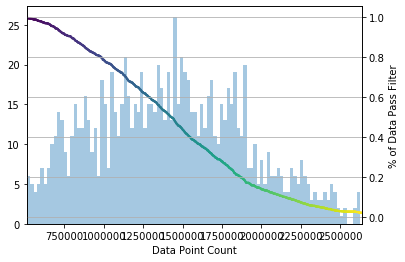

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 1069/1069 (100.0%)
CG_RateAdj passed 1069/1069 (100.0%)
CH_RateAdj passed 1069/1069 (100.0%)
FinalReads passed 1069/1069 (100.0%)
MappingRate passed 1069/1069 (100.0%)
Overall passed 1069/1069 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 10
171207 9
171212 3
171213 29
171214 10
171219 18
180104 19
180109 32
180110 3
180111 1
180122 1
180123 11
180129 12
180130 20
180205 18
180206 21
180208 1
180212 2
180213 1
180220 41
180222 27
180306 6
180312 21
180313 3
180319 4
180320 23
180326 16
180329 21
180402 22
180403 14
180405 39
180412 4
180416 13
180417 9
180419 9
180423 18
180424 9
180426 21
180430 18
180501 9
180514 11
180529 15
180605 26
180612 24
180917 1
180925 4
181002 31
181008 27
181009 28
181022 23
181023 29
181204 1
181206 10
181210 16
181218 7
181220 16
190108 16
190117 14
190122 31
190124 24
190131 52
190205 79
190214 3
190305 3
190307 10


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 125 32.6%
ad002 123 32.0%
ad004 145 37.8%
ad006 121 31.5%
ad007 134 34.9%
ad008 150 39.1%
ad010 139 36.2%
ad012 132 34.4%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
11E_M_1398,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.006453,0.829914,0.828809,0.028019,0.021706,829902.0,2141814,1451286.0,11E,...,12.284189,-21.678234,31.687019,21.745946,L6b,22.984093,14.172984,24.815375,48.398567,True
11E_M_1450,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.006976,0.819126,0.817856,0.033871,0.027084,1126536.0,2376398,1620542.0,11E,...,13.478362,-22.039343,33.417999,17.982367,L6b,22.909222,13.017750,23.774296,46.247783,True
11E_M_1614,/gale/raidix/rdx-4/mapping/11E/CEMBA190305-11E...,0.006742,0.808380,0.807080,0.031253,0.024677,1173324.0,2676826,1845302.0,11E,...,13.583407,-22.047184,33.501984,18.025318,L6b,22.935091,12.928993,23.684744,46.129660,True
11E_M_1708,/gale/raidix/rdx-4/mapping/11E/CEMBA190305-11E...,0.006653,0.833775,0.832662,0.031187,0.024698,1196047.0,2793910,1918542.0,11E,...,12.168572,-21.821011,31.331407,22.227563,L6b,22.872339,14.423399,24.962451,49.014439,True
11E_M_1984,/gale/raidix/rdx-4/mapping/11E/CEMBA190305-11E...,0.006577,0.812213,0.810970,0.031518,0.025106,1401790.0,3133738,2116829.0,11E,...,13.466352,-22.063347,33.391903,17.994191,L6b,23.004164,12.990798,23.696681,46.203082,True
11E_M_831,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.007270,0.809655,0.808261,0.034360,0.027289,1619895.0,3758602,2568364.0,11E,...,13.332649,-21.954754,33.030469,18.383101,L6b,22.976936,13.116368,23.686724,46.282446,True
1B_M_2361,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180213_1B...,0.009450,0.819440,0.817720,0.045820,0.036720,1074009.0,2453422,1569262.0,1B,...,13.168999,-22.047770,33.106632,18.509171,L6b,22.963705,13.127008,23.809863,46.162915,True
1C_M_1848,/gale/raidix/rdx-4/CEMBA_RS1/1C/CEMBA180212_1C...,0.006960,0.837420,0.836280,0.034280,0.027510,1136671.0,2632574,1725763.0,1C,...,11.606767,-21.988220,31.366292,23.126529,L6b,21.951931,14.915560,30.690905,49.440550,True
1C_M_2404,/gale/raidix/rdx-4/CEMBA_RS1/1C/CEMBA180212_1C...,0.004880,0.762320,0.761150,0.016920,0.012100,2938238.0,6404886,4238838.0,1C,...,12.222968,-21.539999,32.210435,23.494987,L6b,22.528805,14.701370,28.023982,49.468016,True
